### Import

In [1]:
import glob
from datetime import date, datetime, timedelta
#from cartopy.crs import NorthPolarStereo, LambertAzimuthalEqualArea
#import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.image
from netCDF4 import Dataset
import numpy as np
from scipy.interpolate import RegularGridInterpolator
from scipy.stats import pearsonr
from scipy.signal import correlate2d
#import xarray as xr
import sklearn.metrics as skm
from PIL import Image

### Importe and structure data

In [2]:
start_date = date(2023, 1, 1)
end_date = date(2023, 5, 30)
path_data = '/home/malela/data/compute/*'

data_p = np.array(())
day_p = []

def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

for single_date in daterange(start_date, end_date):
    #print(single_date.strftime("%Y-%m-%d"))
    day = single_date.strftime("%d")
    month = single_date.strftime("%m")
    year = single_date.strftime("%Y")

    #stat_txt = sorted(glob.glob(path_data + month + day +'.txt'))
    stat_txt = sorted(glob.glob('/home/malela/data/compute/stats_m_'+month+day+'.txt'))
    #print(stat_txt)
    
    if len(stat_txt) > 0:
    
        data_day = []
        with open(stat_txt[0], "r") as file:
                lines = file.readlines()

        # single number
        for i in range (0, 11):
            line = np.array(lines[i]).astype('float32')
            data_day.append(line)

        for j in range (24, 29):
            line = np.array(lines[j]).astype('float32')
            data_day.append(line)

        # lists
        for k in range (11, 15):
            line = np.array(lines[k].split(';')).astype('float32')
            data_day.append(line)

        for h in range (20, 24):
            line = np.array(lines[h].split(';')).astype('float32')
            data_day.append(line)

        # matrix
        cf = np.empty((0, 4))
        for g in range (16,20):
            row = np.array(lines[g].split(';')).astype('float32')
            cf = np.vstack((cf, row))
        data_day.append(cf)

        day_p.append(month +' - '+ day)
        data_p = np.append(data_p, data_day)
        
print(data_p.shape)
        
#print(data_p[2::25])

(1450,)


/home/malela/miniconda3/envs/CNN/lib/python3.10/site-packages/numpy/core/fromnumeric.py:1859: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


In [3]:

matrix = np.array(data_p[::25].tolist())

for i in range (1, 16):
    matrix = np.vstack((matrix, data_p[i::25].tolist()))

for j in range (16, 24):
    for k in range (len(data_p[j::25][0])):
        metric = [liste[k] for liste in data_p[j::25]]
        matrix = np.vstack((matrix, metric))

print(matrix.shape)
        


(51, 58)


### Display data

matrix of correlation of every metrics computed

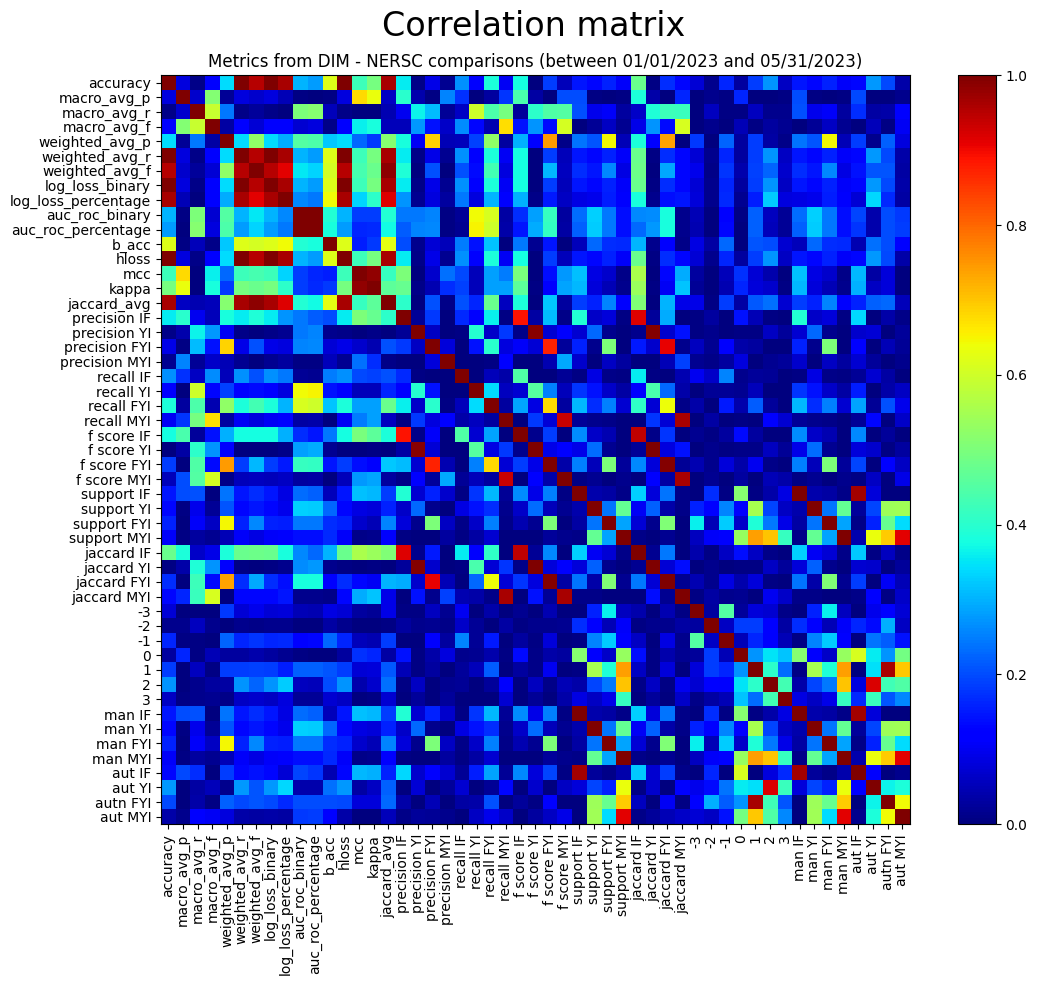

In [4]:
cf = np.corrcoef(matrix)

# Create figure
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot()
fig.subplots_adjust(top=0.2)

# Set titles for the figure and the subplot respectively
fig.suptitle('Correlation matrix                ', fontsize=24, ha='center')
ax.set_title('Metrics from DIM - NERSC comparisons (between 01/01/2023 and 05/31/2023)')

# Display matrix
im = ax.imshow(cf**2, clim=[0, 1], cmap='jet')
cb = plt.colorbar(im, shrink=1)

metrics = ["accuracy", "macro_avg_p", "macro_avg_r", "macro_avg_f", "weighted_avg_p", "weighted_avg_r", "weighted_avg_f",
         "log_loss_binary", "log_loss_percentage", "auc_roc_binary", "auc_roc_percentage", "b_acc", "hloss", "mcc",
         "kappa", "jaccard_avg", "precision IF", "precision YI", "precision FYI", "precision MYI", "recall IF", "recall YI",
         "recall FYI", "recall MYI", "f score IF", "f score YI", "f score FYI", "f score MYI", "support IF", "support YI",
         "support FYI", "support MYI", "jaccard IF", "jaccard YI", "jaccard FYI", "jaccard MYI", "-3", "-2", "-1", "0", "1",
         "2", "3", "man IF", "man YI", "man FYI", "man MYI", "aut IF", "aut YI", "autn FYI", "aut MYI"]

# Show all ticks and label them with the respective list entries
plt.xticks(np.arange(len(metrics)), metrics)
plt.xticks(rotation=90)
plt.xticks(fontsize=10)

plt.yticks(np.arange(len(metrics)), metrics)
plt.yticks(fontsize=10)

fig.tight_layout()
plt.show()

matrix of correlation of retained global metrics

In [5]:
matrix_global = matrix[:16]

for i in reversed ([2, 5, 6, 7, 8, 9, 10, 12, 13, 15]):
    matrix_global = np.delete(matrix_global, i, axis=0)
    
print(matrix_global.shape)

cf_g = np.corrcoef(matrix_global)

(6, 58)


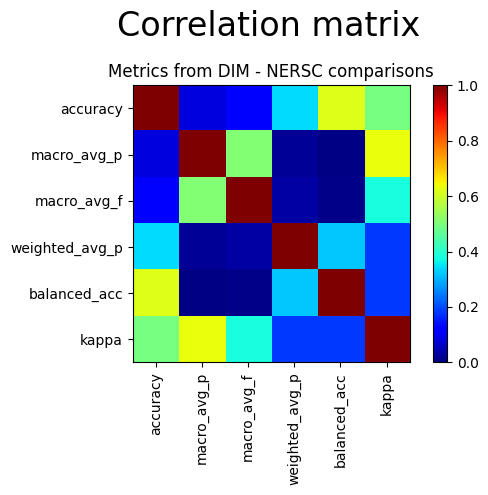

In [6]:
# Create Figure
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot()
#fig.subplots_adjust(top=0.95)
fig.subplots_adjust(top=0.2)

# Set titles for the figure and the subplot respectively
fig.suptitle('Correlation matrix', fontsize=24, ha='center')
ax.set_title('Metrics from DIM - NERSC comparisons')

# Display matrix
im = ax.imshow(cf_g**2, clim=[0, 1], cmap='jet')
cb = plt.colorbar(im, shrink=1)

metrics = ["accuracy", "macro_avg_p", "macro_avg_f", "weighted_avg_p", "balanced_acc", "kappa"]

# Show all ticks and label them with the respective list entries
plt.xticks(np.arange(len(metrics)), metrics)
plt.xticks(rotation=90)
plt.xticks(fontsize=10)

plt.yticks(np.arange(len(metrics)), metrics)
plt.yticks(fontsize=10)

fig.tight_layout()
plt.show()

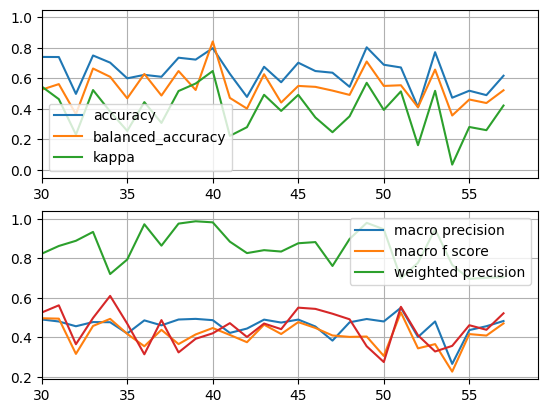

In [8]:
#groupe 1
plt.subplot(211)
lab1 = ['accuracy', 'macro precision', 'macro f score', 'weighted precision', 'balanced_accuracy', 'kappa']
for i in ([0,4, 5]):
    plt.plot(matrix_global[i], label=lab1[i])
    plt.xlim([30, 59])

plt.legend()
plt.grid()

# groupe 2
plt.subplot(212)
for i in ([1,2,3]):
    plt.plot(matrix_global[i], label=lab1[i])
    plt.xlim([30, 59])
plt.plot(matrix[2])
    
plt.legend()
plt.grid()

### Metrics per label 

In [22]:
matrix_l = matrix[16:36]

for i in reversed ([12,13,14,15,16,17,18,19]):
    matrix_l = np.delete(matrix_l, i, axis=0)
    
print(matrix_l.shape)

(12, 58)


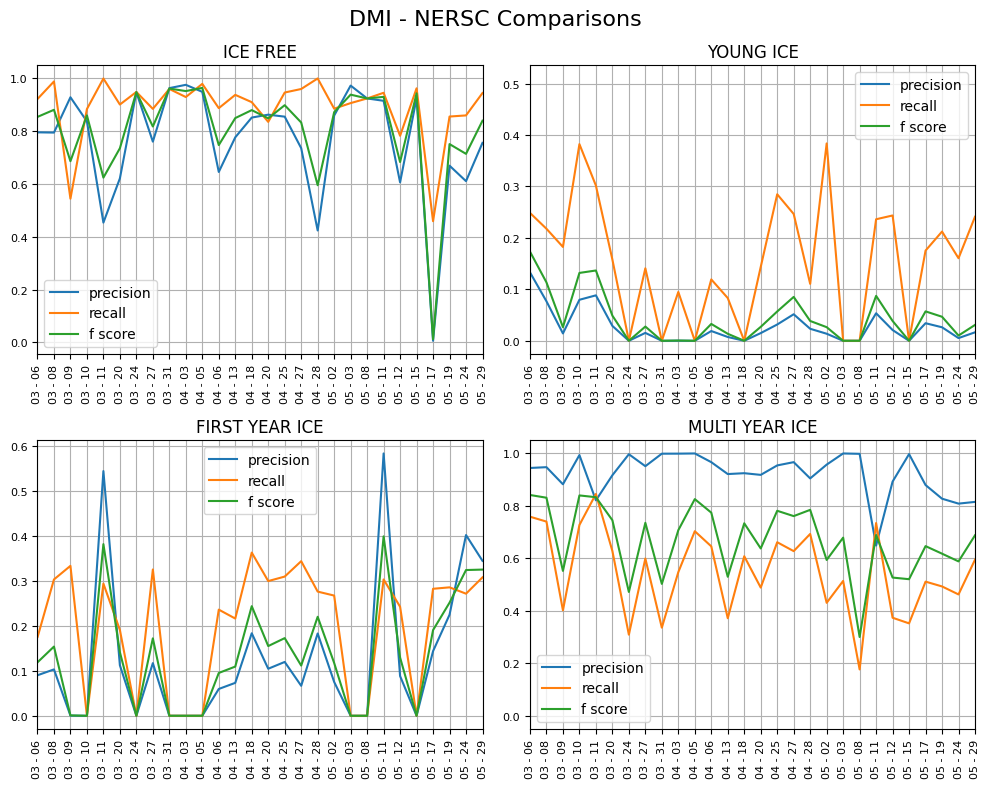

In [23]:
inter = [30,57]
lab = ['precision', 'recall', 'f score']

fig = plt.figure(figsize=(10, 8))
fig.suptitle('DMI - NERSC Comparisons', fontsize=16)

###
plt.subplot(221)
IT = 0
for i in range (3):
    plt.plot(matrix_l[4*i + IT], label=lab[i])
    plt.xticks(np.arange(0, len(day_p)), labels=day_p, rotation='vertical', fontsize=8)
    plt.yticks(fontsize=8)
    plt.xlim(inter)
    
plt.legend()
plt.title('ICE FREE')
plt.grid()

###
plt.subplot(222)
IT = 1
for i in range (3):
    plt.plot(matrix_l[4*i + IT], label=lab[i])
    plt.xticks(np.arange(0, len(day_p)), labels=day_p, rotation='vertical', fontsize=8)
    plt.yticks(fontsize=8)
    plt.xlim(inter)

plt.legend()
plt.title('YOUNG ICE')
plt.grid()

###
plt.subplot(223)

IT = 2
for i in range (3):
    plt.plot(matrix_l[4*i + IT], label=lab[i])
    plt.xticks(np.arange(0, len(day_p)), labels=day_p, rotation='vertical', fontsize=8)
    plt.yticks(fontsize=8)
    plt.xlim(inter)

plt.legend()    
plt.title('FIRST YEAR ICE')
plt.grid()

###
plt.subplot(224)
IT = 3
for i in range (3):
    plt.plot(matrix_l[4*i + IT], label=lab[i])
    plt.xticks(np.arange(0, len(day_p)), labels=day_p, rotation='vertical', fontsize=8)
    plt.yticks(fontsize=8)
    plt.xlim(inter)

plt.legend()    
plt.title('MULTI YEAR ICE')
plt.grid()

fig.tight_layout()

### Compute numbers and percentages

In [13]:
# Number of pixels classified and total of missclassified
miss = []
total = []
for i in range (len(matrix[0])):
    miss.append(matrix[36][i]+matrix[37][i]+matrix[38][i]+matrix[40][i]+matrix[41][i]+matrix[42][i])
    tt = matrix[36][i]+matrix[37][i]+matrix[38][i]+matrix[39][i]+matrix[40][i]+matrix[41][i]+matrix[42][i]
    total.append(tt)

miss = np.array(miss)/500000
cc = np.array(total)/500000

# Number of classes in manual data
nb = (np.array(matrix[43]>0).astype('int8') + np.array(matrix[44]>0).astype('int8')+
     np.array(matrix[45]>0).astype('int8')+np.array(matrix[46]>0).astype('int8'))/4

# Percentage of auto px
a1 = matrix[47]/np.array(total)
a2 = matrix[48]/np.array(total)
a3 = matrix[49]/np.array(total)
a4 = matrix[50]/np.array(total)

# Percentage of man px
m1 = matrix[43]/np.array(total)
m2 = matrix[44]/np.array(total)
m3 = matrix[45]/np.array(total)
m4 = matrix[46]/np.array(total)

### Plot

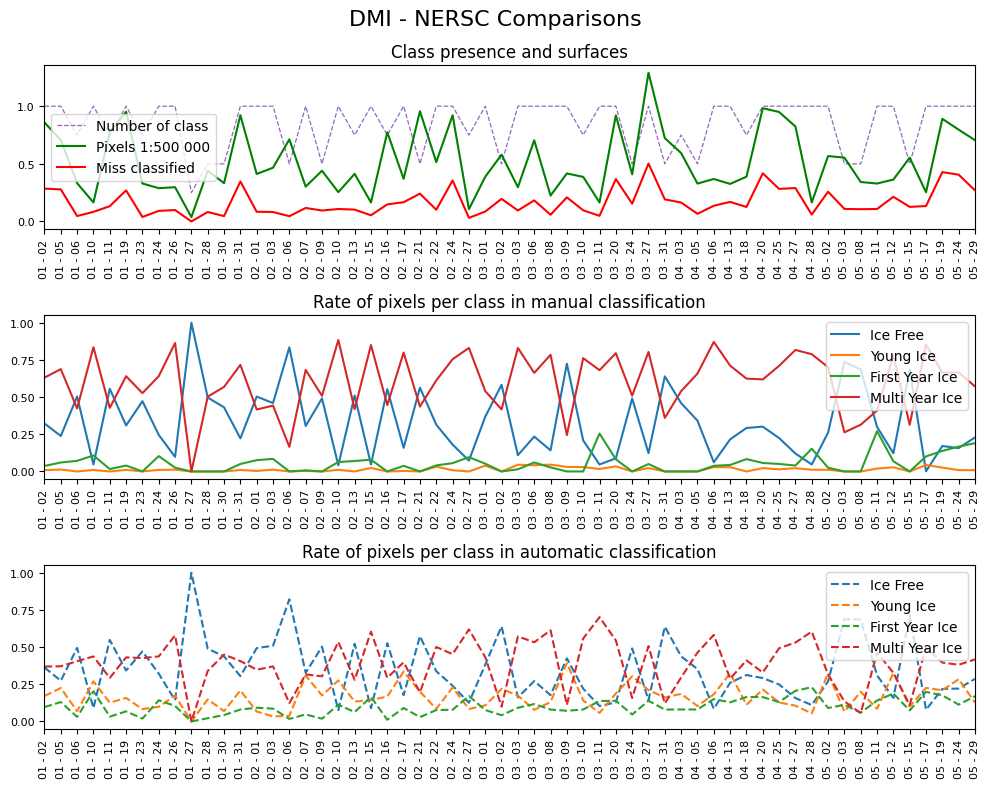

In [14]:
# Display
fig = plt.figure(figsize=(10, 8))
fig.suptitle('DMI - NERSC Comparisons', fontsize=16)

# Number of classes in manual data
plt.subplot(311)
plt.plot(nb, '--',linewidth=.9, color='tab:purple', label='Number of class')
plt.plot(cc, color='green', label='Pixels 1:500 000')
plt.plot(miss, color='red', label='Miss classified')
plt.title('Class presence and surfaces')
plt.xlim([30,57])
plt.xticks(np.arange(0, len(day_p)), labels=day_p, rotation='vertical', fontsize=8)
plt.yticks(fontsize=8)

plt.legend()

# Percentage in manual classif
plt.subplot(312)
plt.plot(m1, color='tab:blue', label='Ice Free')
plt.plot(m2, color='tab:orange', label='Young Ice')
plt.plot(m3, color='tab:green', label='First Year Ice')
plt.plot(m4, color='tab:red', label='Multi Year Ice')
plt.title('Rate of pixels per class in manual classification')
plt.xlim([30,57])
plt.xticks(np.arange(0, len(day_p)), labels=day_p, rotation='vertical', fontsize=8)
plt.yticks(fontsize=8)
plt.yticks(fontsize=8)

plt.legend()

# Percentage in auto classif
plt.subplot(313)
plt.plot(a1, '--',color='tab:blue', label='Ice Free')
plt.plot(a2, '--',color='tab:orange', label='Young Ice')
plt.plot(a3, '--',color='tab:green', label='First Year Ice')
plt.plot(a4, '--',color='tab:red', label='Multi Year Ice')
plt.title('Rate of pixels per class in automatic classification')
plt.xlim([30,57])
plt.xticks(np.arange(0, len(day_p)), labels=day_p, rotation='vertical', fontsize=8)
plt.yticks(fontsize=8)

plt.legend()

fig.tight_layout()


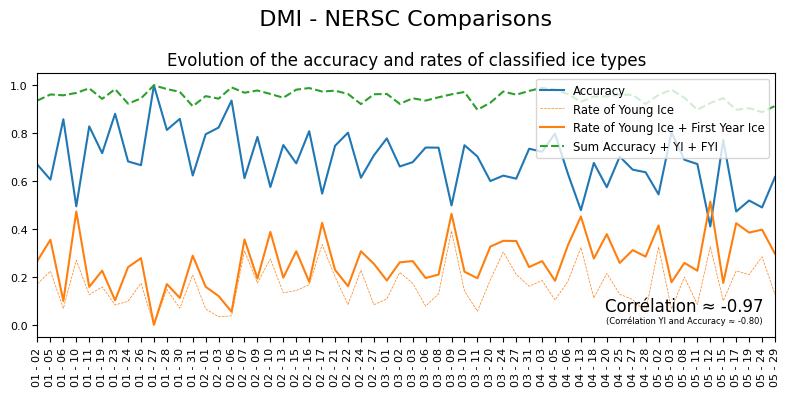

In [15]:
# Display
fig = plt.figure(figsize=(8, 4))
fig.suptitle('   DMI - NERSC Comparisons', fontsize=16)

#### Number of classes in manual data
plt.subplot(111)
plt.plot(matrix[0], label='Accuracy')
plt.plot(a2, '--',color='tab:orange', linewidth=0.5,label='Rate of Young Ice')
plt.plot(a2+a3, label='Rate of Young Ice + First Year Ice')
plt.plot(matrix[0]+a2+a3, '--', label='Sum Accuracy + YI + FYI')
plt.title('Evolution of the accuracy and rates of classified ice types')
plt.xlim([30,57])
plt.xticks(np.arange(0, len(day_p)), labels=day_p, rotation='vertical', fontsize=8)
plt.yticks(fontsize=8)

plt.text(50,0.08, "Corrélation ≈ -0.97", size=12, ha="center", va="center")
plt.text(50,0.02, "(Corrélation YI and Accuracy ≈ -0.80)", size=6, ha="center", va="center")

plt.legend(fontsize='small', loc=1)

#fig.subplots_adjust(hspace=0.2)
fig.tight_layout()

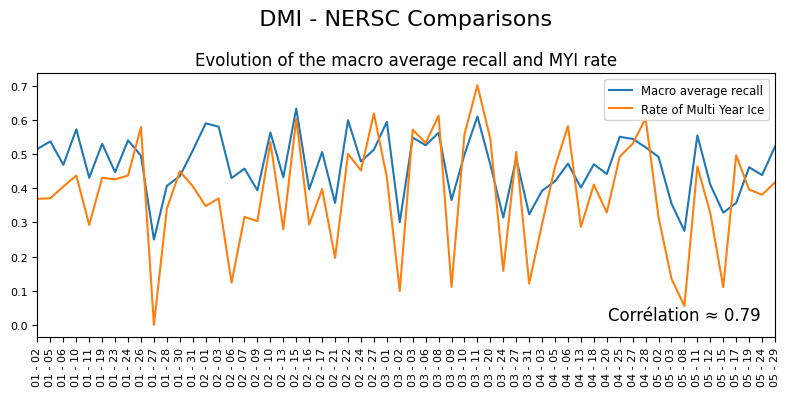

In [16]:
# Display
fig = plt.figure(figsize=(8, 4))
fig.suptitle('   DMI - NERSC Comparisons', fontsize=16)

#### Number of classes in manual data
plt.subplot(111)
plt.plot(matrix[2], label='Macro average recall')
plt.plot(a4, color='tab:orange',label='Rate of Multi Year Ice')
plt.title('Evolution of the macro average recall and MYI rate')
plt.xlim([30,57])
plt.xticks(np.arange(0, len(day_p)), labels=day_p, rotation='vertical', fontsize=8)
plt.yticks(fontsize=8)

plt.text(50,0.03, "Corrélation ≈ 0.79", size=12, ha="center", va="center")

plt.legend(fontsize='small', loc=1)

#fig.subplots_adjust(hspace=0.2)
fig.tight_layout()

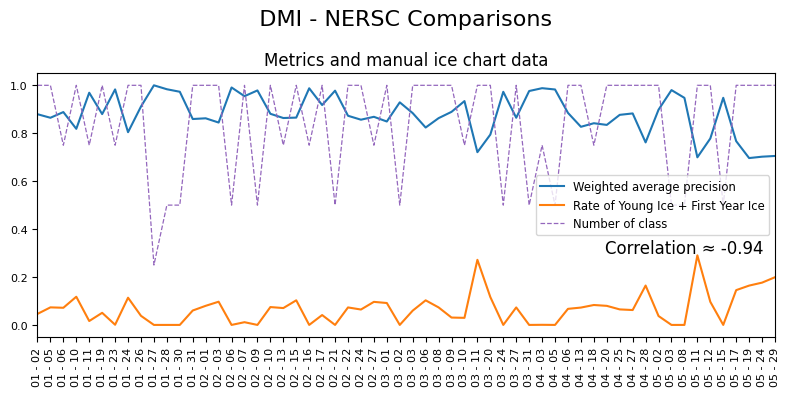

In [17]:
# Display
fig = plt.figure(figsize=(8, 4))
fig.suptitle('   DMI - NERSC Comparisons', fontsize=16)

#### Number of classes in manual data
plt.subplot(111)
plt.plot(matrix[4], label='Weighted average precision')
plt.plot(m2+m3, label='Rate of Young Ice + First Year Ice')
plt.plot(nb, '--',linewidth=.9, color='tab:purple', label='Number of class')
#plt.plot(matrix[0]+a2+a3, '--', label='Sum Accuracy + YI + FYI')
plt.title('Metrics and manual ice chart data')
plt.xlim([30,57])
plt.xticks(np.arange(0, len(day_p)), labels=day_p, rotation='vertical', fontsize=8)
plt.yticks(fontsize=8)

plt.text(50,0.32, "Correlation ≈ -0.94", size=12, ha="center", va="center")
#plt.text(50,0.02, "(Corrélation YI and Accuracy ≈ -0.80)", size=6, ha="center", va="center")

plt.legend(fontsize='small', loc=7)

#fig.subplots_adjust(hspace=0.2)
fig.tight_layout()

In [18]:
np.corrcoef(matrix[4], m2+m3)

array([[ 1.        , -0.93760075],
       [-0.93760075,  1.        ]])

In [19]:
miss_c = []
miss_blue = []
miss_red = []

for i in range (len(matrix[0])):
    miss_c.append(matrix[36][i]+matrix[37][i]+matrix[38][i]+matrix[40][i]+matrix[41][i]+matrix[42][i])
    miss_blue.append(matrix[36][i]+matrix[37][i]+matrix[38][i])
    miss_red.append(matrix[40][i]+matrix[41][i]+matrix[42][i])

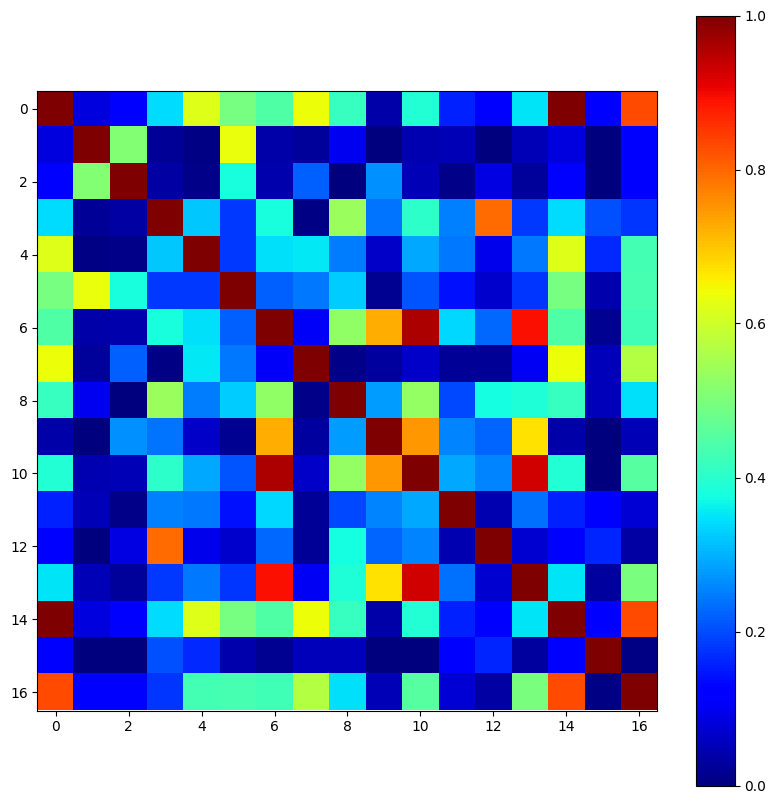

In [21]:
mat = np.vstack((matrix_global, a1))
mat = np.vstack((mat, a2))
mat = np.vstack((mat, a3))
mat = np.vstack((mat, a4))

"""mat = np.vstack((mat, a1+a2))
mat = np.vstack((mat, a1+a3))
mat = np.vstack((mat, a1+a4))
mat = np.vstack((mat, a2+a3))    #13
mat = np.vstack((mat, a2+a4))
mat = np.vstack((mat, a3+a4))
mat = np.vstack((mat, a1+a2+a3))
mat = np.vstack((mat, a1+a2+a4))
mat = np.vstack((mat, a1+a3+a4))
mat = np.vstack((mat, a2+a3+a4))"""

mat = np.vstack((mat, m1))
mat = np.vstack((mat, m2))
mat = np.vstack((mat, m3))
mat = np.vstack((mat, m4))

"""mat = np.vstack((mat, m1+m2))    
mat = np.vstack((mat, m1+m3))
mat = np.vstack((mat, m1+m4))   #26
mat = np.vstack((mat, m2+m3))   #27
mat = np.vstack((mat, m2+m4))
mat = np.vstack((mat, m3+m4))
mat = np.vstack((mat, m1+m2+m3))
mat = np.vstack((mat, m1+m2+m4))
mat = np.vstack((mat, m1+m3+m4))
mat = np.vstack((mat, m2+m3+m4))"""

################

mat = np.vstack((mat, miss_c/cc))
mat = np.vstack((mat, miss_blue/cc))
mat = np.vstack((mat, miss_red/cc))
                                      
cmr = np.corrcoef(mat)
                   
                   #####
fig = plt.figure(figsize=(10,10))



im = plt.imshow(cmr**2, clim=[0, 1], cmap='jet')
cb = plt.colorbar(im, shrink=1)

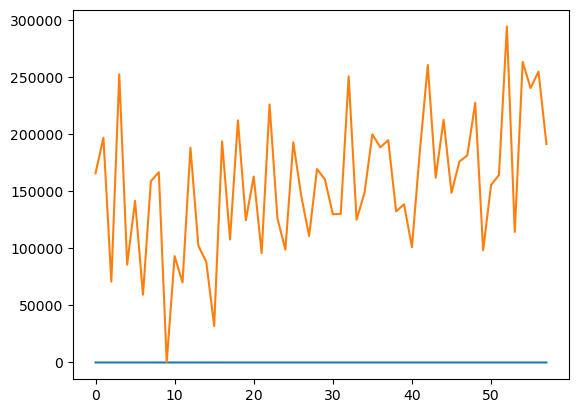

In [29]:
plt.plot(mat[0])
plt.plot(mat[14])